In [50]:
%reload_ext autoreload
%autoreload 2
import tensorflow as tf
import collections
import sys
import math
import numpy as np
sys.path.append('../../pytools')
import d2l
import os

d2l.gpu_mem_init()

Memory growth enabled for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): True


In [51]:
class Seq2SeqEncoder(d2l.Encoder):
    """用于序列到序列学习的循环神经网络编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super().__init__(*kwargs)
        # 嵌入层
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells(
            [tf.keras.layers.GRUCell(num_hiddens, dropout=dropout)
             for _ in range(num_layers)]), return_sequences=True,
                                       return_state=True)

    def call(self, X, *args, **kwargs):
        # 输入'X'的形状：(batch_size,num_steps)
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X)
        output = self.rnn(X, **kwargs)
        state = output[1:]
        return output[0], state

In [52]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
X = tf.zeros((4, 7))
output, state = encoder(X, training=False)
output.shape

TensorShape([4, 7, 16])

In [53]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
X = tf.zeros((4, 7))
output, state = encoder(X, training=False)
output.shape, len(state), X.shape

(TensorShape([4, 7, 16]), 2, TensorShape([4, 7]))

In [54]:
class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells(
            [tf.keras.layers.GRUCell(num_hiddens, dropout=dropout)
             for _ in range(num_layers)]), return_sequences=True,
                                       return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def call(self, X, state, **kwargs):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X)
        # 广播context，使其具有与X相同的num_steps
        ## fix begin，原文这个地方报错，fix如下
        context = tf.repeat(tf.expand_dims(state[-1][-1], axis=1), repeats=X.shape[1], axis=1)
        ## fix end
        X_and_context = tf.concat((X, context), axis=2)
        rnn_output = self.rnn(X_and_context, state, **kwargs)
        output = self.dense(rnn_output[0])
        # output的形状:(batch_size,num_steps,vocab_size)
        # state是一个包含num_layers个元素的列表，每个元素的形状:(batch_size,num_hiddens)
        return output, rnn_output[1:]

In [55]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
X_enc = encoder(X)
state = decoder.init_state(X_enc)
print(f"zjtest X_enc_0.shape:{X_enc[0].shape}, state.shape:{tf.convert_to_tensor(state[-1][-1]).shape}")
output, state = decoder(X, state, training=False)
output.shape,tf.convert_to_tensor(state).shape

zjtest X_enc_0.shape:(4, 7, 16), state.shape:(4, 16)


/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:1484: UserWarning: Layer 'seq2_seq_decoder_9' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''got an unexpected keyword argument 'kwargs'''
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'seq2_seq_decoder_9', however the layer does not have a `build()` method implemented and it looks like it ha

(TensorShape([4, 7, 10]), TensorShape([2, 1, 4, 16]))

In [56]:
#@save
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.shape[1]
    mask = tf.range(start=0, limit=maxlen, dtype=tf.float32)[
        None, :] < tf.cast(valid_len[:, None], dtype=tf.float32)

    if len(X.shape) == 3:
        return tf.where(tf.expand_dims(mask, axis=-1), X, value)
    else:
        return tf.where(mask, X, value)

X = tf.constant([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, tf.constant([1, 2]))

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 0, 0],
       [4, 5, 0]], dtype=int32)>

In [57]:
#@save
class MaskedSoftmaxCELoss(tf.keras.losses.Loss):
    """带遮蔽的softmax交叉熵损失函数"""
    def __init__(self, valid_len):
        super().__init__(reduction='none')
        self.valid_len = valid_len

    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def call(self, label, pred):
        weights = tf.ones_like(label, dtype=tf.float32)
        weights = d2l.sequence_mask(weights, self.valid_len)
        ## 传入的label应该是int32，这里变成float32了，cast一下
        label_one_hot = tf.one_hot(tf.cast(label, tf.int32), pred.shape[-1])
        unweighted_loss = tf.keras.losses.CategoricalCrossentropy(
            from_logits=True, reduction='none')(label_one_hot, pred)
        weighted_loss = tf.reduce_mean((unweighted_loss*weights), axis=1)
        return weighted_loss

In [58]:
loss = MaskedSoftmaxCELoss(tf.constant([4, 2, 0]))
loss(tf.ones((3,4), dtype = tf.int32), tf.ones((3, 4, 10), dtype=tf.int32)).numpy()

array([2.3025851, 1.1512926, 0.       ], dtype=float32)

In [59]:
#@save
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    animator = d2l.Animator(xlabel="epoch", ylabel="loss",
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # 训练损失总和，词元数量
        for batch in data_iter:
            X, X_valid_len, Y, Y_valid_len = [x for x in batch]
            bos = tf.reshape(tf.constant([tgt_vocab['<bos>']] * Y.shape[0]),
                             shape=(-1, 1))
            dec_input = tf.concat([bos, Y[:, :-1]], 1)  # 强制教学
            with tf.GradientTape() as tape:
                Y_hat, _ = net(X, dec_input, X_valid_len, training=True)
                l = MaskedSoftmaxCELoss(Y_valid_len)(Y, Y_hat)
            gradients = tape.gradient(l, net.trainable_variables)
            gradients = d2l.grad_clipping(gradients, 1)
            optimizer.apply_gradients(zip(gradients, net.trainable_variables))
            num_tokens = tf.reduce_sum(Y_valid_len).numpy()
            metric.add(tf.reduce_sum(l), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

loss 0.063, 557.5 tokens/sec on <tensorflow.python.eager.context._EagerDeviceContext object at 0x7fde19e70080>


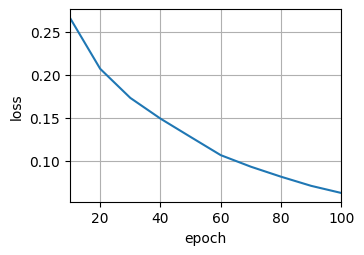

In [60]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 100, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
print(f"src_vocab_size:{len(src_vocab)}, dst_vocab_size:{len(tgt_vocab)}")
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [61]:
#@save
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    save_attention_weights=False):
    """序列到序列模型的预测"""
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = tf.constant([len(src_tokens)])
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴
    enc_X = tf.expand_dims(src_tokens, axis=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len, training=False)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = tf.expand_dims(tf.constant([tgt_vocab['<bos>']]), axis=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state, training=False)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = tf.argmax(Y, axis=2)
        pred = tf.squeeze(dec_X, axis=0)
        # 保存注意力权重
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred.numpy())
    return ' '.join(tgt_vocab.to_tokens(tf.reshape(output_seq,
        shape = -1).numpy().tolist())), attention_weight_seq

In [62]:
def bleu(pred_seq, label_seq, k):  #@save
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        if len_pred - n + 1 <= 0:
            return -1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [63]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => vas-y ., bleu 0.000
i lost . => je me <unk> ., bleu 0.000
he's calm . => il est riche ., bleu 0.658
i'm home . => je suis paresseux ., bleu 0.512
